# Introduction

### Problem

In the project this week, we will conduct detailed model evaluation, data quality testing and behavioral testing for the news classification model from the week 1 project.

1. We will look at evaluation metrics beyond overall accuracy and f1 score (per-class metrics, confusion matrix, per-class false positive and false negative errors)
2. We will implement bootstrap sampling to measure confidence intervals of model performance metrics
3. We will implement behavioral tests using a popular open source library called checklist
4. [advanced] Advanced data quality and behavioral tests

### Deliverables
1. Test set per-class accuracy, precision, recall and F-1 score
2. Test set confusion matrix, and per-class false positive, false negative errors
3. 95% confidence intervals for test set metrics as estimated via bootstrap sampling
4. Behavioral tests for the trained news classification model, using checklist.
5. [Optional] Advanced data quality and behavioral tests



## Step1: Prereqs & Installation

Download & Import all the necessary libraries we need throughout the project.

In [ ]:
!pip install checklist
!jupyter nbextension install --py --sys-prefix checklist.viewer
!jupyter nbextension enable --py --sys-prefix checklist.viewer

In [ ]:
# Install all the required dependencies for the project

!pip install numpy
!pip install scikit-learn
!pip install gensim
!pip install sentence-transformers
!pip install matplotlib
!pip install great_expectations

In [2]:
# Package imports that will be needed for this project

import numpy as np
import json
from sentence_transformers import SentenceTransformer
from pprint import pprint
from sklearn.linear_model import LogisticRegression
from sklearn import metrics as sklearn_metrics

In [3]:
# Global Constants

LABEL_SET = [
    'Business',
    'Sci/Tech',
    'Software and Developement',
    'Entertainment',
    'Sports',
    'Health',
    'Toons',
    'Music Feeds'
]

EMBEDDING_MODEL = 'all-mpnet-base-v2'
DATA_URL = 'https://corise-mlops.s3.us-west-2.amazonaws.com/project2/agnews.zip'

## Step 2: Download and Load Dataset

[AG News](http://groups.di.unipi.it/~gulli/AG_corpus_of_news_articles.html) is a collection of more than 1 million news articles gathered from more than 2000 news sources by an academic news search engine. The news topic classification dataset & benchmark was first used in [Character-level Convolutional Networks for Text Classification (NIPS 2015)](https://arxiv.org/abs/1509.01626). The dataset has the text description (summary) of the news article along with some metadata. **For this project, we will use a slightly modified (cleaned up) version of this dataset**

Schema:
* Source - News publication source
* URL - URL of the news article
* Title - Title of the news article
* Description - Summary description of the news article
* Embedding - 768 dimensional embedding representation of the news article text (description)
* Category (Label) - News category

Sample row in this dataset:
```
{
   'description': 'A capsule carrying solar material from the Genesis space probe has made a crash landing at a US Air Force training facility in the US state of Utah.',
   'id': 86273,
   'label': 'Entertainment',
   'source': 'Voice of America',
   'title': 'Capsule from Genesis Space Probe Crashes in Utah Desert',
   'Embedding': [....],
   'url': 'http://www.sciencedaily.com/releases/2004/09/040908090621.htm'
}
```

In [4]:
from urllib.request import urlopen
from io import BytesIO
from zipfile import ZipFile

DIRECTORY_NAME = "data"


def download_dataset():
    """
    Download the dataset. The zip contains three files: train.json, test.json and unlabeled.json
    """
    http_response = urlopen(DATA_URL)
    zipfile = ZipFile(BytesIO(http_response.read()))
    zipfile.extractall(path=DIRECTORY_NAME)


# Expensive operation so we should just do this once
download_dataset()


In [5]:
Datasets = {}

for ds in ['train', 'test']:
    with open('data/{}.json'.format(ds), 'r') as f:
        Datasets[ds] = json.load(f)
    print("Loaded Dataset {0} with {1} rows".format(ds, len(Datasets[ds])))

print("\nExample dataset row:\n")
pprint(Datasets['train'][0])

Loaded Dataset train with 25000 rows
Loaded Dataset test with 50000 rows

Example dataset row:

{'description': 'A capsule carrying solar material from the Genesis space '
                'probe has made a crash landing at a US Air Force training '
                'facility in the US state of Utah.',
 'embedding': [0.014944990165531635,
               -0.012602416798472404,
               0.022629551589488983,
               -0.004524254705756903,
               0.030837086960673332,
               -0.036378033459186554,
               -0.009855341166257858,
               0.03661152347922325,
               0.006519013550132513,
               0.01946776919066906,
               -0.04761530086398125,
               0.022138206288218498,
               0.032830338925123215,
               0.04278254881501198,
               0.02766306698322296,
               0.043008096516132355,
               0.0386490561068058,
               0.009227401576936245,
               -0.0084016676992177

## Step 3: Data Quality Tests

In Week 2 instruction, we learned about the importance of evaluating data quality across the ML lifecycle:
* When building your first ML model, you often have no data and have to invest in annotation resources to get labels
* Dataset labels can be noisy as they are collected from a variety of different sources.
* Real world evolves (drift) and so should the datasets you’re using to train models (to make sure they evolve along with it).

[Great Expectations](https://docs.greatexpectations.io/docs/) is a popular Python library for validating data in Machine Learning pipelines. It contains several built-in Expectation types to configure tests, as well as integrations with common data structures used to store datasets (e.g. Pandas dataframes, CSV files, MySQL databases etc). We will be using this library to define and run some data quality tests for our dataset. The goal and scope of the exercise here is to get you acquainted with the library and practice of testing for data quality.

Useful references for this section:
1. Documentation: https://docs.greatexpectations.io/docs/
2. Using Great Expections in Jupyter: https://docs.greatexpectations.io/docs/guides/miscellaneous/how_to_quickly_explore_expectations_in_a_notebook
3. List of predefined Expecations: https://greatexpectations.io/expectations/
4. Creating custom Expecations for Pandas dataframes: https://github.com/great-expectations/great_expectations/blob/develop/docs_rtd/guides/how_to_guides/creating_and_editing_expectations/how_to_create_custom_expectations_for_pandas.rst

In [42]:
import pandas as pd
import great_expectations as ge
from great_expectations.dataset import PandasDataset, MetaPandasDataset

class AGNewsPandasDataset(PandasDataset):

    _data_asset_type = "AGNewsPandasDataset"

    @MetaPandasDataset.column_map_expectation
    def expect_column_string_not_null_or_empty(self, column):
        """
        [TO BE IMPLEMENTED]

        Write a custom expectation that checks that the string column's value for each
        row is not NULL and not an empty string

        Your code should look something like this:
        column.map(lambda x: ...)
        """
        return column.map(lambda x: (x is not None) & (len(x) > 0) )

    @MetaPandasDataset.column_map_expectation
    def expect_column_embedding_dimensionality(self, column, dimension):
        """
        [TO BE IMPLEMENTED]

        Write a custom expectation that checks that the embedding column's value for each
        row is not NULL and dim(embedding) == dimension

        Your code should look something like this:
        column.map(lambda x: ...)
        """
        return column.map(lambda x: (len(x) == dimension) & (x is not None))

    @MetaPandasDataset.column_map_expectation
    def expect_column_in_range(self, column, range_min, range_max):
        """
        [TO BE IMPLEMENTED]

        Write a custom expectation that checks that the column's value for each
        row is in range [range_min, range_max]

        Your code should look something like this:
        column.map(lambda x: ...)
        """
        return column.map(lambda x: range_min <= float(x) <= range_max)

    @MetaPandasDataset.column_map_expectation
    def expect_column_embedding_unit_norm(self, column):
        """
        [TO BE IMPLEMENTED]

        Write a custom expectation that checks that the embedding column's value for each
        row is not NULL and norm(embedding) == 1

        Your code should look something like this:
        column.map(lambda x: ...)
        """
        return column.map(lambda x: round(np.linalg.norm(np.array(x)), 5) == 1.0)


In [43]:
Dataframes = {}

for ds in ['train', 'test']:
    Dataframes[ds] = ge.from_pandas(
        pd.DataFrame.from_records(Datasets[ds]),
        dataset_class=AGNewsPandasDataset
    )

In [44]:
for ds in ['train', 'test']:
    """
    [TO BE IMPLEMENTED]

    Expect columns in Dataframes[ds] to match the column set:
    {'id', 'source', 'title', 'url', 'rank', 'description', 'embedding', 'label'}
    """
    expected_colnames = ['id', 'source', 'title', 'url', 'rank', 'description', 'embedding', 'label']
    Dataframes[ds].expect_table_columns_to_match_ordered_list(expected_colnames)

    """
    [TO BE IMPLEMENTED]

    Expect the "id" column in Dataframes[ds] to be unique
    """
    Dataframes[ds].expect_column_values_to_be_unique(column = 'id')

    """
    [TO BE IMPLEMENTED]

    Expect the "description" column in Dataframes[ds] not not be null or empty
    """
    Dataframes[ds].expect_column_string_not_null_or_empty(column = 'description')

    """
    [TO BE IMPLEMENTED]

    Expect the "embedding" column in Dataframes[ds] should be non-NULL and dimensionality = 768
    (Run this after implementing `expect_column_embedding_dimensionality` above)
    """
    Dataframes[ds].expect_column_embedding_dimensionality(column = 'embedding', dimension = 768)

    """
    [TO BE IMPLEMENTED]

    Expect the "embedding" column in Dataframes[ds] should be unit norm vectors
    (Run this after implementing `expect_column_embedding_unit_norm` above)
    """
    Dataframes[ds].expect_column_embedding_unit_norm(column = 'embedding')

    """
    [TO BE IMPLEMENTED]

    Expect the "rank" column in Dataframes[ds] should be in range [1, 5]
    """
    Dataframes[ds].expect_column_in_range(column = 'rank', range_min = 1, range_max = 5)

In [45]:
validation_train = Dataframes["train"].validate()

pprint(validation_train)

{
  "success": false,
  "statistics": {
    "evaluated_expectations": 6,
    "successful_expectations": 5,
    "unsuccessful_expectations": 1,
    "success_percent": 83.33333333333334
  },
  "meta": {
    "great_expectations_version": "0.16.16",
    "expectation_suite_name": "default",
    "run_id": {
      "run_name": null,
      "run_time": "2023-06-15T01:52:14.314767+00:00"
    },
    "batch_kwargs": {
      "ge_batch_id": "3bc562d2-0b1f-11ee-ab30-0242ac1c000c"
    },
    "batch_markers": {},
    "batch_parameters": {},
    "validation_time": "20230615T015214.313994Z",
    "expectation_suite_meta": {
      "great_expectations_version": "0.16.16"
    }
  },
  "evaluation_parameters": {},
  "results": [
    {
      "success": true,
      "exception_info": {
        "raised_exception": false,
        "exception_message": null,
        "exception_traceback": null
      },
      "result": {
        "observed_value": [
          "id",
          "source",
          "title",
          "url"

In [46]:
validation_test = Dataframes["test"].validate()

pprint(validation_test)

{
  "success": false,
  "statistics": {
    "evaluated_expectations": 6,
    "successful_expectations": 5,
    "unsuccessful_expectations": 1,
    "success_percent": 83.33333333333334
  },
  "meta": {
    "great_expectations_version": "0.16.16",
    "expectation_suite_name": "default",
    "run_id": {
      "run_name": null,
      "run_time": "2023-06-15T01:52:16.342982+00:00"
    },
    "batch_kwargs": {
      "ge_batch_id": "3be82da8-0b1f-11ee-ab30-0242ac1c000c"
    },
    "batch_markers": {},
    "batch_parameters": {},
    "validation_time": "20230615T015216.342881Z",
    "expectation_suite_meta": {
      "great_expectations_version": "0.16.16"
    }
  },
  "evaluation_parameters": {},
  "results": [
    {
      "success": true,
      "exception_info": {
        "raised_exception": false,
        "exception_message": null,
        "exception_traceback": null
      },
      "result": {
        "observed_value": [
          "id",
          "source",
          "title",
          "url"

In [6]:
"""
[TO BE IMPLEMENTED]

Take a look at the results from the data validation tests. You will observe that some rows in the
training and test sets have failed the validation for the following test:

Expect the "description" column in Dataframes[ds] not not be null or empty

This is a good catch! We know that these rows in training or test set likely just add noise to the model
since it is not very relevant to ask the model to predict the category of a news article with no text.

In this step, you will filter out the rows from Datasets['train'] and Datasets['test']
and create a new Datasets_filtered object with the filtered datasets
"""

Datasets_filtered = {}
Datasets_filtered['train'] = [x for x in Datasets['train'] if (x['description'] is not None) & (len(x['description'])>0)]
Datasets_filtered['test'] = [x for x in Datasets['test'] if (x['description'] is not None) & (len(x['description'])>0)]

In [7]:
len(Datasets_filtered['train']), len(Datasets_filtered['test'])

(24736, 49486)

## Step 4: Fine-grained Model Evaluation

Model performance evaluation for real-world ML applications can often be complex since different stakeholders (ML engineers, product managers, sales teams) care about the impact on different dimensions. In this exercise, we will evaluate the News category classification from Week 1 in the following ways:


* **Aggregate performance metrics**: Using standard metrics to evaluate ML model performance such as accuracy, mean squared error, BLEU scores etc (depending on the ML task) is a necessary first step, but far from sufficient. It serves to filter out models that are clearly suboptimal and reduces risk of launching bad models

* **Slice-level performance metrics**: It is important to track model performance not just in aggregate but for important cohorts/slices of your traffic. For example, it is important to track the performance of your hate speech detection model not just in aggregate but for traffic from each country, language etc to understand the gaps in performance.

* **Qualitative evaluations**: Behavioral tests can be helpful to root-cause individual instances of model failures and yield helpful insights to improve models

In [49]:
# In order to minimize variations from different model architectures & training procedures,
# we will keep the model architecture and feature sets uniform

X_train, Y_train = [], []
X_test, Y_true = [], []

for row in Datasets_filtered['train']:
    X_train.append(row['embedding'])
    Y_train.append(row['label'])

for row in Datasets_filtered['test']:
    X_test.append(row['embedding'])
    Y_true.append(row['label'])

model = LogisticRegression(
    multi_class='multinomial',
    tol=0.001,
    solver='saga',
)
model.fit(X_train, Y_train)
Y_pred = model.predict(X_test)

In [50]:
## This should be roughly in the same range as the results you got in Week 1

print("Accuracy on test set: {}".format(sklearn_metrics.accuracy_score(Y_true, Y_pred)))


  and should_run_async(code)



Accuracy on test set: 0.7895364345471446


## Step 4 (Part 1): Confusion Matrix and Slice-based evaluation

As we saw with issues discussed around rare classes and model bias, evaluating the performance metrics at the overall dataset level is often not enough to deploy in production. Here are some commonly used axes along which ML teams commonly slice their datasets:

1. Labels (i.e. per-class performance)
2. Key categorical features or buckets of continuous features. E.g. a recommender system’s performance for each gender, age group.
3. Key traffic cohorts as defined by business value/regulatory requirements. E.g. a recommender system’s performance for newly registered users (it is important they have a good product experience else they will stop using the product)

In this exercise, we will dig into per-class performance

  and should_run_async(code)



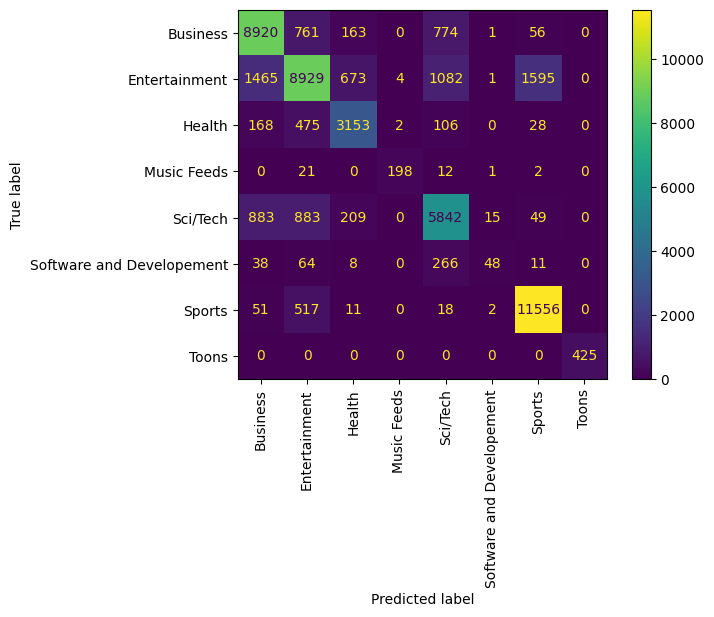

In [51]:
"""
[TO BE IMPLEMENTED]

Plot a confusion matrix for the news category classification model trained above.
You should have a NxN matrix M, where
N = len(LABEL_SET)
M(i, j) = number of instances in the test set where true_label = LABEL_SET[i] and pred_label = LABEL_SET[j]

Hint: check out sklearn.metrics

"""
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

y_pred = model.predict(X_test)
cm = confusion_matrix(Y_true, Y_pred, labels = model.classes_)

cm_display = ConfusionMatrixDisplay(cm, display_labels = model.classes_).plot(xticks_rotation = 'vertical')

In [52]:
"""
[TO BE IMPLEMENTED]

Compute the precision, recall and F1 score per-class for the test set

Hint: check out sklearn.metrics
"""

from sklearn.metrics import classification_report
print(classification_report(Y_true, Y_pred))


  and should_run_async(code)



                           precision    recall  f1-score   support

                 Business       0.77      0.84      0.80     10675
            Entertainment       0.77      0.65      0.70     13749
                   Health       0.75      0.80      0.77      3932
              Music Feeds       0.97      0.85      0.90       234
                 Sci/Tech       0.72      0.74      0.73      7881
Software and Developement       0.71      0.11      0.19       435
                   Sports       0.87      0.95      0.91     12155
                    Toons       1.00      1.00      1.00       425

                 accuracy                           0.79     49486
                macro avg       0.82      0.74      0.75     49486
             weighted avg       0.79      0.79      0.78     49486



In [53]:
import random

def confusion_matrix_errors(dataset, true_label, pred_label, class_1, class_2, num_errors=100):
    """
    [TO BE IMPLEMENTED]

    Write a function `confusion_matrix_errors` that accepts the following inputs:
    1. The test dataset
    2. True and predicted labels for each row in the dataset
    3. A pair of labels (T, P)

    And returns the `num_errors` no. of errors from the test dataset where true_label = T and pred_label = P
    """
    pairs = list(zip(true_label, pred_label))
    idx = [id for (id, pair) in enumerate(pairs) if pair[0]!=pair[1]]
    errors = [dataset[i] for i in idx]
    return random.sample(errors, num_errors)


"""
[TO BE IMPLEMENTED]
Use the function implemented above to get some insights about the kind of examples that the model
is confused about for a given pair of classes
Some pairs to try out: ('Entertainment', 'Sports'), ('Health', 'Sports'), ('Business', 'Sci/Tech')
"""
for e in confusion_matrix_errors(Datasets['test'], Y_true, Y_pred, 'Entertainment', 'Sports'):
    print(e['description'])

  and should_run_async(code)



The iPod is proving a colossal hit on the Japanese electronics and entertainment giant's home ground. The tiny white machine is catching on as a fashion statement and turning into a cultural icon here, much the same way it won a fanatical following in the United States.
Young Renault drivers scored two new podiums!
The athletes have packed up. Olympic banners are coming down. But another challenge for the city of Athens is just beginning. It #39;s a realization that #39;s just starting to hit the Olympic hosts
A director of business software maker Peoplesoft says the firm may be ready to negotiate with its would-be buyer, Oracle.
Film character  #39;Godzilla #39;, center, poses with, from left, Los Angeles councilmember Tom LaBonge, Japanese film producer Shogo Tomiyama, honorary Mayor of Hollywood Johnny Grant, actor Masahiro Matsuoka, director Ryuhei Kitamura, actress Rei Kiku Kawa and
AP - Lisa Marie Presley is keeping Graceland but selling the bulk of the Elvis estate, including ri

## Step 4 (Part 2): Estimating confidence intervals with Bootstrap sampling

When computing model performance metrics, the margin of error can vary a lot depending on the size of the test dataset. We are trying to estimate the model’s performance on any unseen data by empirically computing the model performance on the held-out test set, and trying to quantify the confidence intervals in this estimation: If we were to measure the model’s performance on another independently collected test dataset from the same underlying distribution, our model’s performance on this dataset is unlikely to be the same, but how different might they plausibly be?

In this exercise, we will implement Bootstrap sampling to estimate the 95% confidence interval for
overall accuracy and F1-score of the model:

1. Generate N ‘bootstrap sample’ datasets, each the same size as the original test set. Each bootstrap sample dataset is obtained by sampling instances uniformly at random from the original test set (with replacement).
2. On each of the bootstrap sample datasets, calculate the accuracy metric.
3. From Step (2), you will end up with N different accuracy values. Sort them.
4. The 95% confidence interval is given by the 2.5th to the 97.5th percentile among the N sorted accuracy values.


In [54]:
def bootstrap_accuracy_distribution(Y_true, Y_pred, N = 1000):
    """
    [TO BE IMPLEMENTED]

    Implement this function that takes two lists: Y_true, Y_pred
    and the number of bootstrap trials (N).

    It should return a list (ret) of length = N, where ret[i] = accuracy metric from i-th bootstrap sampling run
    """
    from sklearn.metrics import accuracy_score as acc

    pairs = list(zip(Y_true, Y_pred))
    ret = []

    for n in range(N):
      #Sampling 25% of the data
      data_sample = random.sample(pairs, int(len(pairs)*0.25))
      ret.append(acc(y_true = [pair[0] for pair in data_sample] , y_pred = [pair[1] for pair in data_sample]))

    return ret



95 percent confidence interval: [0.7835259881982055, 0.7954086169266834]


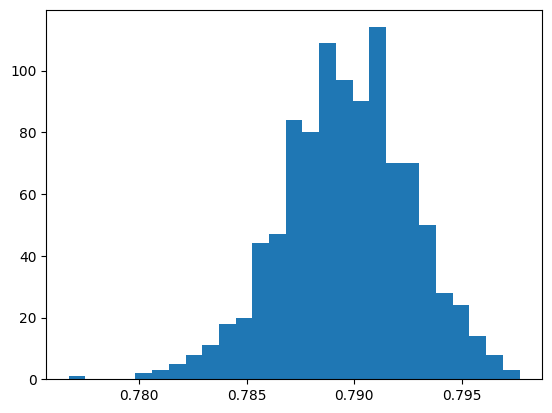

In [55]:
import matplotlib.pyplot as plt
NUM_BOOTSTRAP = 1000

bs_vals = bootstrap_accuracy_distribution(Y_true, Y_pred, NUM_BOOTSTRAP)
bs_vals = sorted(bs_vals)

print("95 percent confidence interval: [{0}, {1}]".format(
    bs_vals[25],    # 2.5th percentile
    bs_vals[975]    # 97.5th percentile
))

_ = plt.hist(bs_vals, bins='auto')
plt.show()

## Step 4 (Part 3): Minimum Functionality behavioral Tests

Unit tests and integration tests play an important role in testing software for bugs, inefficiencies and potential vulnerabilities. Can we employ a similar approach to testing ML models? This exercise introduces the concept of “behavioral testing”  for machine learning models.

Minimum Functionality Tests are a class of behavioral tests, and equivalents of “unit tests in software engineering” - a collection of simple examples (and labels) to check a behavior. A recommended practice is to write minimum functionality tests for highly visible/high cost potential failure modes, and for failure modes that you uncover during error analysis to guard against such failures in the future.

For this exercise, we will use a popular open source library called [Checklist](https://github.com/marcotcr/checklist) to configure and run behavioral tests for our model. The goal and scope of the exercise here is to get you acquainted with the library and practice of testing for minimum functionality.

Useful references:
1. Getting started with Checklist: https://github.com/marcotcr/checklist
2. Creating & Running tests with Checklist: https://github.com/marcotcr/checklist/blob/9baab717e44e216697f7ef0730ee269db9ef7d5b/notebooks/tutorials/3.%20Test%20types,%20expectation%20functions,%20running%20tests.ipynb

In [56]:
import checklist
from checklist.editor import Editor
from checklist.test_types import MFT
from checklist.pred_wrapper import PredictorWrapper

# Run some warmup code to get you familiar with templates in checlist
editor = Editor()
ret = editor.template('{first_name} is {a:profession} from {country}.',
                      profession=['lawyer', 'doctor', 'accountant'])
np.random.choice(ret.data, 3)

  and should_run_async(code)



array(['Susan is a lawyer from Haiti.', 'Alice is a lawyer from Tunisia.',
       'Jonathan is an accountant from Qatar.'], dtype='<U67')

In [57]:
"""
[TO BE IMPLEMENTED]

Part 1: Data Generation for behavioral tests

1. News Source variation:
{source}: Astronomers expect the Perseid meteor shower to be one of the best versions of the shooting star events in several years
source = ['New York Times', 'Reuters', 'AP', 'Wall Street Journal', 'Quanta', 'BBC', 'BBC UK', 'Yahoo News']
labels = "Sci/Tech"

2. Company Name variation:
{company} revealed Thursday that its old recipe of adding stores is longer is a source of new profits for the company.
company = ['McDonalds', 'Starbucks', 'Chipotle', 'Krispy Creme', 'Unknown Company']
labels = "Sci/Tech"

3.
{disease} will come under the {mask} during the charity gala event being held on Monday at 7pm
disease = ['Breast cancer', 'Heart disease', 'Diabetes']
labels = "Health"
"""

editor = Editor()
# [TO BE IMPLEMENTED]
source = ['New York Times', 'Reuters', 'AP', 'Wall Street Journal', 'Quanta', 'BBC', 'BBC UK', 'Yahoo News']
ret = editor.template('{source}: Astronomers expect the Perseid meteor shower to be one of the best versions of the shooting star events in several years',
                      source= source, labels="Sci/Tech", save=True, nsamples=100)

company = ['McDonalds', 'Starbucks', 'Chipotle', 'Krispy Creme', 'Unknown Company']
ret += editor.template('{company} revealed Thursday that its old recipe of adding stores is longer is a source of new profits for the company.',
                        company = company, labels = "Sci/Tech", save = True, nsamples = 100)

disease = ['Breast cancer', 'Heart disease', 'Diabetes']
ret += editor.template('{disease} will come under the {mask} during the charity gala event being held on Monday at 7pm',
                       disease = disease, labels = "Health", save = True, nsamples = 100)





In [58]:
"""
Part 2: Test Configuration
"""

test = MFT(**ret, name='AG News MFT tests')

In [59]:
"""
Part 3: Test Run & Results summary
"""

def encode_and_predict(inputs):
    encoder = SentenceTransformer(
        'sentence-transformers/{model}'.format(model=EMBEDDING_MODEL)
    )
    encodings = [encoder.encode(x, normalize_embeddings=True) for x in inputs]
    return model.predict(encodings)

# wrapped_pp returns a tuple with (predictions, softmax confidences)
wrapped_pp = PredictorWrapper.wrap_predict(encode_and_predict)
test.run(wrapped_pp, overwrite=True)
test.summary()

Predicting 300 examples
Test cases:      300
Fails (rate):    100 (33.3%)

Example fails:
Business Chipotle revealed Thursday that its old recipe of adding stores is longer is a source of new profits for the company.
----
Business Chipotle revealed Thursday that its old recipe of adding stores is longer is a source of new profits for the company.
----
Business McDonalds revealed Thursday that its old recipe of adding stores is longer is a source of new profits for the company.
----


In [60]:
#test.visual_summary()

  and should_run_async(code)



## Step 5: [Optional] Advanced data quality and behavioral tests

In the previous steps, you have familiarized yourself with libraries for writing data quality tests (great expectations) and behavioral tests (checkist). Take it out for a spin! A few possible extensions you can try:

1. **Model invariance behavioral tests** -- in step 4, we wrote some minimum functionality tests. Can you design some useful invariance behavioral tests?

2. **Embedding drift based data quality checks across Training/Test datasets** -- in step 3, we wrote some data quality tests. If we wanted to check for drift in embedding space between training and test data, how might we construct a data quality test for this? Hint: The distribution of euclidean distance between pairs of embeddings within the training, and between the training and test dataset should be “almost the same”



# Model Invariance

Preconfigured perturbation: changing names present in articles

In [61]:
import spacy
from checklist.test_types import MFT, INV
from checklist.perturb import Perturb
nlp = spacy.load("en_core_web_sm")

In [62]:
dataset = [x['description'] for x in Datasets_filtered['test']][:500]

In [63]:
pdataset = list(nlp.pipe(dataset))


In [64]:
t = Perturb.perturb(pdataset, Perturb.change_names, keep_original=True)
t.data[:3]

[['NEW YORK (Billboard) - After several years spent exploring  the roots and branches of bluegrass music with his recordings,  Ricky Skaggs is satisfying his critics with an album of all new  material.',
  'NEW YORK (Billboard) - After several years spent exploring  the roots and branches of bluegrass music with his recordings,  Michael Howard is satisfying his critics with an album of all new  material.',
  'NEW YORK (Billboard) - After several years spent exploring  the roots and branches of bluegrass music with his recordings,  Christopher Barnes is satisfying his critics with an album of all new  material.',
  'NEW YORK (Billboard) - After several years spent exploring  the roots and branches of bluegrass music with his recordings,  Matthew Wright is satisfying his critics with an album of all new  material.',
  'NEW YORK (Billboard) - After several years spent exploring  the roots and branches of bluegrass music with his recordings,  David Mitchell is satisfying his critics with a

In [65]:
test2 = INV(**t)

In [66]:
test2.run(wrapped_pp, overwrite=True)
test2.summary()

Predicting 1221 examples
Test cases:      111
Fails (rate):    14 (12.6%)

Example fails:
Entertainment St. Andrews, Scotland (Sports Network) - Northern Ireland #39;s Graeme McDowell matched the course record of 10-under-par 62 at St.
Sports St. Andrews, Scotland (Sports Network) - Northern Ireland #39;s Michael Clark matched the course record of 10-under-par 62 at St.
Sports St. Andrews, Scotland (Sports Network) - Northern Ireland #39;s Christopher Phillips matched the course record of 10-under-par 62 at St.

----
Sports Alex Ferguson has moved quickly to put a protective shield around teenage striker Wayne Rooney - and Manchester United #39;s new record signing insists he is mature enough to evade the pitfalls that could derail his emerging career.
Entertainment William Baker has moved quickly to put a protective shield around teenage striker Wayne Rooney - and Manchester United #39;s new record signing insists he is mature enough to evade the pitfalls that could derail his emergin

Custom perturbations: changing the source of the article

In [67]:
import re
def change_sources(x, meta=False, *args, **kwargs):
    # Returns empty or a list of strings with sources changed
    sources = ['New York Times', 'Reuters', 'AP', 'Wall Street Journal', 'Quanta', 'BBC', 'BBC UK', 'Yahoo News']
    ret = []
    ret_meta = []
    for p in sources:
        if re.search(r'\b%s\b' % p, x):
            ret.extend([re.sub(r'\b%s\b' % p, p2, x) for p2 in sources if p != p2])
            ret_meta.extend([(p, p2) for p2 in sources if p != p2])
    if meta:
        return ret, ret_meta
    else:
        return ret

  and should_run_async(code)



In [68]:
change_sources(dataset[0], meta=True)

(['New York Times - Ellis L. Marsalis Sr., the patriarch of a family of world famous jazz musicians, including grandson Wynton Marsalis, has died. He was 96.',
  'Reuters - Ellis L. Marsalis Sr., the patriarch of a family of world famous jazz musicians, including grandson Wynton Marsalis, has died. He was 96.',
  'Wall Street Journal - Ellis L. Marsalis Sr., the patriarch of a family of world famous jazz musicians, including grandson Wynton Marsalis, has died. He was 96.',
  'Quanta - Ellis L. Marsalis Sr., the patriarch of a family of world famous jazz musicians, including grandson Wynton Marsalis, has died. He was 96.',
  'BBC - Ellis L. Marsalis Sr., the patriarch of a family of world famous jazz musicians, including grandson Wynton Marsalis, has died. He was 96.',
  'BBC UK - Ellis L. Marsalis Sr., the patriarch of a family of world famous jazz musicians, including grandson Wynton Marsalis, has died. He was 96.',
  'Yahoo News - Ellis L. Marsalis Sr., the patriarch of a family of w

In [69]:
t2 = Perturb.perturb(dataset, change_sources, keep_original=True)
t2.data[:3]

[['AP - Ellis L. Marsalis Sr., the patriarch of a family of world famous jazz musicians, including grandson Wynton Marsalis, has died. He was 96.',
  'New York Times - Ellis L. Marsalis Sr., the patriarch of a family of world famous jazz musicians, including grandson Wynton Marsalis, has died. He was 96.',
  'Reuters - Ellis L. Marsalis Sr., the patriarch of a family of world famous jazz musicians, including grandson Wynton Marsalis, has died. He was 96.',
  'Wall Street Journal - Ellis L. Marsalis Sr., the patriarch of a family of world famous jazz musicians, including grandson Wynton Marsalis, has died. He was 96.',
  'Quanta - Ellis L. Marsalis Sr., the patriarch of a family of world famous jazz musicians, including grandson Wynton Marsalis, has died. He was 96.',
  'BBC - Ellis L. Marsalis Sr., the patriarch of a family of world famous jazz musicians, including grandson Wynton Marsalis, has died. He was 96.',
  'BBC UK - Ellis L. Marsalis Sr., the patriarch of a family of world fam

In [70]:
test3 = INV(**t2)

In [71]:
test3.run(wrapped_pp, overwrite=True)
test3.summary()

Predicting 568 examples
Test cases:      71
Fails (rate):    7 (9.9%)

Example fails:
Sci/Tech NEW YORK (Reuters Health) - The brain's response to another  person's body language may help explain why humans are quite  efficient at fleeing from danger, according to researchers.
Health NEW YORK (New York Times Health) - The brain's response to another  person's body language may help explain why humans are quite  efficient at fleeing from danger, according to researchers.
Health NEW YORK (Wall Street Journal Health) - The brain's response to another  person's body language may help explain why humans are quite  efficient at fleeing from danger, according to researchers.

----
Business WASHINGTON (Reuters) - World Bank President James  Wolfensohn told the Bush administration on Monday that he will  leave his post at mid-year, triggering a hunt for a replacement  for the top job at the global lender.
Entertainment WASHINGTON (New York Times) - World Bank President James  Wolfensohn told th

# Embedding drift

Distribution of pairwise euclidean distances (within train set and between train and test sets)

In [8]:
from sklearn.metrics import pairwise_distances
from random import shuffle

In [9]:
len(Datasets_filtered['train']), len(Datasets_filtered['test'])

(24736, 49486)

In [10]:
xtrain = [x['embedding'] for x in Datasets_filtered['train']]
xtest = [x['embedding'] for x in Datasets_filtered['test']]

shuffle(xtrain)
shuffle(xtest)

#Issues with the RAM, so we take a sample
xtrain = xtrain[:5000]
xtest = xtest[:5000]

In [12]:
%%time
train_distances = pairwise_distances(xtrain, metric='euclidean')
train_distances = np.array(train_distances)
train_distances = train_distances[np.tril_indices(n = len(train_distances), k = 0)]


train_test_distances = pairwise_distances(xtrain + xtest, metric='euclidean')
train_test_distances = np.array(train_test_distances)
train_test_distances = train_test_distances[np.tril_indices(n = len(train_test_distances), k = 0)]

CPU times: user 14.1 s, sys: 4.39 s, total: 18.5 s
Wall time: 10.3 s


In [22]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
plt.style.use('ggplot')

In [18]:
df_distances = pd.DataFrame({'distances': list(train_distances) + list(train_test_distances),
                         'dataset': ['train']*len(train_distances) + ['train-test']*len(train_test_distances)})

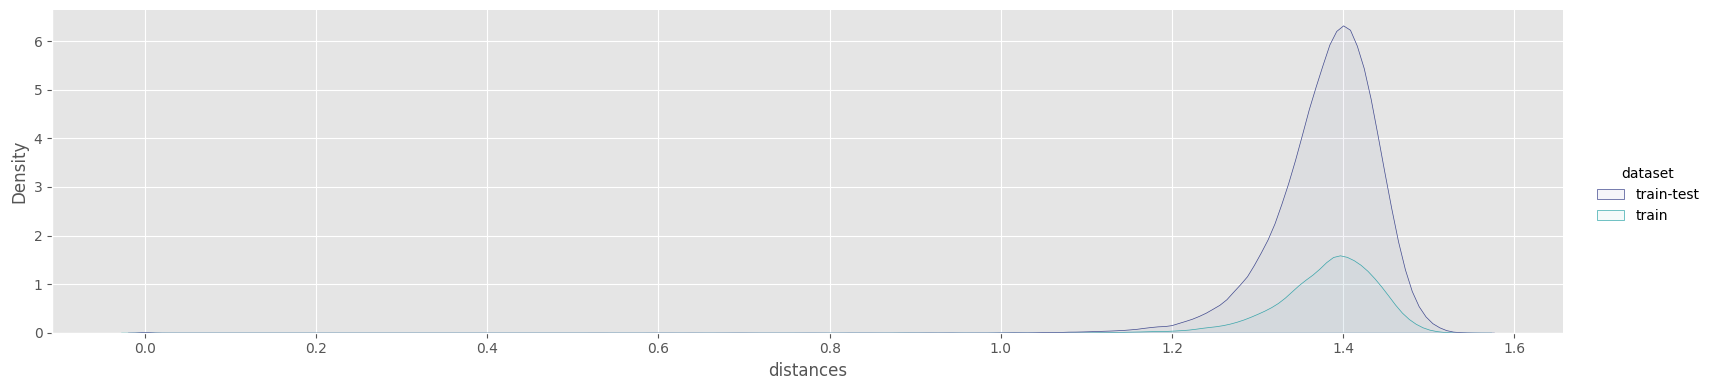

In [30]:
sns.displot(data=df_distances.sample(100000),
            x="distances",
            hue = "dataset",
            kind = 'kde',
            aspect = 4,
            height = 4,
            alpha = 0.05,
            fill = True,
            palette = 'mako');

In [34]:
print(f"Train distances mean: {np.mean(train_distances)}")
print(f"Train distances variance: {np.var(train_distances)}")

print(f"Train-test distances mean: {np.mean(train_test_distances)}")
print(f"Train-test distances variance: {np.var(train_test_distances)}")

Train distances mean: 1.3794143413636297
Train distances variance: 0.004501278817527963
Train-test distances mean: 1.3799470270528857
Train-test distances variance: 0.004116440913945715
